# Lab 7: Recurrent Network Atchitectures

### James O. Thomas
### Xiaoxian Jing
### Kuang Yan

1. [Data Selection](#data_selection) <br>
  1.1 [Stock Prices Example](#pure_stock) <br>
  1.2 [Stock Prices and News](#stock_and_news) <br>
2. [Preparation](#preparation) <br>
  2.1 [Class Variables](#class_varibles) <br>
  2.2 [Metrics](#metrics) <br>
  2.3 [Test-Train Split](#test_train_split) <br>
3. [Modeling](#modeling) <br>
  3.1 [Architectures](#architectures) <br>
  3.2 [Second Recurrent Chain](#second_chain) <br>
  3.3 [Evaluation](#evaluation) <br>
4. [Exceptional Work](#exceptional_work) <br>
  4.1 [Additional Analysis](#additional_analysis) <br>
  4.2 [Fourier Filtering](#Fourier_filter) <br>
  4.3 [Visualize Word Embeddings](#visualize_embeddings) <br>
  .. 4.3.1 [t-SNE](#tSNE) <br>
  .. 4.3.2 [PCA](#PCA) <br>
  4.4 [Novel Text](#novel_text) <br>
  ... 4.4.1 [Word by Word](#word_by_word) <br>
  ... 4.4.2 [Character by Character](#character_by_character) <br>
5. [Final Thoughts](#final_thoughts) <br>

<a id="data_selection"></a>

# Data Selection

> Select a dataset similarly to lab one:text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

For this lab we will be using stock prices and news. There are several ways to get historical stock prices (see below), but getting historical news headlines is somewhat harder. Therefore we will use the kaggle data set from https://www.kaggle.com/aaron7sun/stocknews. This source aggregated the news headlines from reddit (that's somewhat scary) and the stock information is from yahoo finance.

<a id="pure_stock"></a>

## Stock Prices Example

Below is an example of retrieving pure stock prices

In [149]:
# pure stock prices using pandas_datareader
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(2008, 8, 8)
end = dt.datetime.now()

# dow https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
# S&P 500
# Nasdaq

tsla_df = web.DataReader("TSLA", 'yahoo', start, end)
msft_df = web.DataReader("MSFT", 'yahoo', start, end)
dji_df = web.DataReader('^DJI', 'yahoo', start, end) # 'yahoo', 'fred'?
gspc_df = web.DataReader('^GSPC', 'yahoo', start, end) # 'yahoo', 'fred'?

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_stock(df, title=''):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(df['High'], label='High')
    ax.plot(df['Low'], label='Low')
    ax.plot(df['Open'], label='Open')
    ax.plot(df['Close'], label='Close')
    ax.plot(df['Adj Close'], label='Adj Close')
    ax.set(title=title, ylabel='price', xlabel='date')
    plt.xticks(rotation=45)
    l = ax.legend()
    fig.show()

In [151]:
dji_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11759.959961,11388.040039,11432.089844,11734.320312,212830000,11734.320312
2008-08-11,11867.110352,11675.530273,11729.669922,11782.349609,183190000,11782.349609
2008-08-12,11782.349609,11601.519531,11781.700195,11642.469727,173590000,11642.469727
2008-08-13,11633.780273,11453.339844,11632.809570,11532.959961,182550000,11532.959961
2008-08-14,11718.280273,11450.889648,11532.070312,11615.929688,159790000,11615.929688


C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


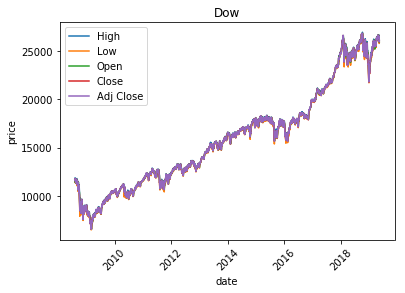

In [152]:
plot_stock(dji_df, title='Dow')

<a id="stock_and_news"></a>

## Stock Prices and News

Now we will import the stock and news prices for use in this lab.

In [115]:
import pandas as pd
DJIA_df = pd.read_csv('Archive_2/DJIA_table.csv')
news_df = pd.read_csv('Archive_2/Combined_News_DJIA.csv')

FileNotFoundError: File b'Archive_2/DJIA_table.csv' does not exist

In [ ]:
DJIA_df.reindex(index=DJIA_df.index[::-1])
DJIA_df.head()

In [ ]:
DJIA_df['Change'] = DJIA_df['Close'].diff()
DJIA_df['Change'] = DJIA_df['Change'].shift(-1)
DJIA_df.head()

In [ ]:
DJIA_df.dropna(inplace=True)
DJIA_df.isna().sum()

<a id="preparation"></a>

# Preparation

<a id="class_variables"></a>
    
## Class Variables

> __[10 points]__ Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). __Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.__ 

The data contains 6 numeric features for each day: opening stock price, high stock price, low stock price, closing stock price, volume (number of stocks), and adjusted close. The adjusted closing price is calculated by yahoo and takes into account things such as dividends paid or stock splits, as well as new stock offerings. All of these features will be normalized to floats using min/max scaling. We also use the headlines included in the data set. The words in these headlines are converted to vectors using GloVe.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# how do you normalize these? How do you not data snoop?
Data_df = DJIA_df[[col for col in list(DJIA_df) if (col != 'Change' and col != 'Date')]]
Target_df = DJIA_df['Change']

# now the normalization
min_max_scaler = MinMaxScaler()
X_data = min_max_scaler.fit_transform(Data_df.values)
Y = Target_df.values

In [ ]:
def make_datasets(X, Y, length=60):
    if len(X) != len(Y):
        print('you done messed up')
    X_data_list = []
    Y_data_list = []
    for i in range(length, len(X)):
        X_data_list.append(X[i-length:i,:])
        Y_data_list.append(Y[i])
    X_data = np.array(X_data_list)
    Y_data = np.array(Y_data_list)
    return(X_data, Y_data)

In [ ]:
X_DJIA, Y = make_datasets(X_data, Y)

In [ ]:
news_df.head()

In [ ]:
news_df.drop(columns=['Date','Label'],inplace=True)

In [ ]:
news_df['All'] = ''
for col in news_df:
    if col!='All':
        news_df['All'] += news_df[col]
news_df = news_df.astype(str)

In [ ]:
NUM_TOP_WORDS = None
MAX_ART_LEN = 50 # maximum and minimum number of words

X_news = []

#to make sure each news is MAX_ART_LEN, thus seperatable
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(news_df['All'])

for col in news_df:
    if col!='All':
        sequences = tokenizer.texts_to_sequences(news_df[col])
        X_tmp = pad_sequences(sequences, maxlen=MAX_ART_LEN,padding='pre')
        X_news += [X_tmp]


word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

In [ ]:
X_news = [news[60:-1] for news in X_news]

In [ ]:
X_final = X_news + [X_DJIA]
Idx = np.array([i for i in range(len(X_DJIA))])
Idx_train, Idx_test = train_test_split(Idx, test_size=0.1,random_state=42)
X_train = [_[Idx_train] for _ in X_final]
X_test = [_[Idx_test] for _ in X_final]
Y_train = Y[Idx_train]
Y_test = Y[Idx_test]

<a id="metrics"></a>

## Metrics

> __[10 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why is the metric appropriate for the task (_e.g._, in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

During training of our model we will monitor the mean squared error (mse) between the predicted next day closing value and the actual next day closing value. However, we will also use the predictions from a trained model to calculate how much money we would have if we had invested it at a specific time. For this get_rich metric we will use several simplifications. We will ignore any trading fees associated with buying/selling stocks and we will also assume we will buy partial stocks. We will also assume that we can sell and buy the stocks requested immediately. 

In [24]:
def get_rich(y_hats, y, amount=1e4, print_steps=False, print_results=True):
    if len(y_hats) != len(y):
        print("you will never get rich if you can't count")
        return None
    
    riches = amount
    n_shares = 0
    own = False # start not owning any shares
    n_shares_list = []
    
    # loop over the days buying and selling
    for i in range(0, len(y_hats)-1):
        if print_steps:
            print('buy')
        if y_hats[i][0] > 0:
            # predicted increase so buy if you don't already own
            # if you already own, just hold onto the stocks
            if not own:
                n_shares = riches/y[i]
                riches = 0
                own = True
        else:
            if print_steps:
                print('sell')
            # predicted decrease so sell if you own
            if own:
                riches = n_shares*y[i]
                n_shares = 0
                own = False
        n_shares_list.append(n_shares)
    # assume you always sell on the last day
    if own:
        riches = n_shares*y[-1]
    
    if print_results:
        print('We ended up with ${:.2f} which is a {:2f}% change'.format(riches, (riches-amount)/amount*100))
    return riches, n_shares_list

<a id="test_train_split"></a>

## Test-Train Split

> __[10 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate.__ Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For this project we will use an 80/20 split for training/testing. We will use the first 80% of the data as the training and the last 20% for testing. We need to preserver the time sequence in our data so we cannot randomly choose the testing and training data. This splitting also matches our custom get_rich metric where we will theoretically invest $10,000 at the time corresponding to the end of the training data and calculate how much money we would have at the end of the testing data. 

<a id="modeling"></a>

# Modeling

<a id="architectures"></a>

## Architectures

> __[20 points]__ Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [ ]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import concatenate

NEW_NUM = 5

EMBED_SIZE = 51

all_inputs = []

#RNN for all top 25 news share same embeding and RNN layers, defined as below
news_embeding_layer = Embedding(top_words, # input dimension (max int of OHE)
                    EMBED_SIZE, # output dimension size
                    input_length=MAX_ART_LEN)
news_rnn_layer = SimpleRNN(25,dropout=0.2, recurrent_dropout=0.2)


#first news pass through the RNN
news_input = Input(shape=(MAX_ART_LEN, ))
all_inputs.append(news_input)

input_embed = news_embeding_layer(news_input)
print(input_embed.shape)
x_tmp = news_rnn_layer(input_embed)
x_news = x_tmp


#all rest news pass through the RNN, and concanate them, also need to specify the input
for start in range(1,25):
    news_input = Input(shape=(MAX_ART_LEN, ))
    all_inputs.append(news_input)
    input_embed = news_embeding_layer(news_input)
    x_tmp = news_rnn_layer(input_embed)
    x_news = concatenate([x_news, x_tmp])


x_news = Dense(NEW_NUM, activation='sigmoid')(x_news)

news_model=Model(inputs=all_inputs,outputs=x_news)

news_model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
#news_model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(news_model).create(prog='dot', format='svg'))

In [ ]:
BATCH_SIZE = 2
TIME_STEPS = 60
feature_num = 6

DIJA_input=Input(shape=(TIME_STEPS,feature_num))
DJIA_rnn_layer=LSTM(10)
x_DIJA = DJIA_rnn_layer(DIJA_input)
DJIA_model = Model(inputs=DIJA_input,outputs=x_DIJA)

all_inputs.append(DIJA_input)

DJIA_model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
DJIA_model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(DJIA_model).create(prog='dot', format='svg'))

In [ ]:
x_final = concatenate([x_news, x_DIJA])
x = Dense(1, activation='relu')(x_final)

final_model=Model(inputs=all_inputs,outputs=x)

final_model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['accuracy'])
#final_model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(final_model).create(prog='dot', format='svg'))

In [ ]:
def wraped_model(rnn_news_type=SimpleRNN,rnn_DJIA_type=LSTM):
    all_inputs = []
        
    NEWS_NUM = 2
    EMBED_SIZE = 51
    
    news_embeding_layer = Embedding(top_words,
                        EMBED_SIZE,
                        input_length=MAX_ART_LEN)
    news_rnn_layer = rnn_news_type(10,dropout=0.2, recurrent_dropout=0.2)
    
    news_input = Input(shape=(MAX_ART_LEN, ))
    all_inputs.append(news_input)
    input_embed = news_embeding_layer(news_input)
    x_tmp = news_rnn_layer(input_embed)
    x_news = x_tmp
    for start in range(1,25):
        news_input = Input(shape=(MAX_ART_LEN, ))
        all_inputs.append(news_input)
        input_embed = news_embeding_layer(news_input)
        x_tmp = news_rnn_layer(input_embed)
        x_news = concatenate([x_news, x_tmp])
    x_news = Dense(NEWS_NUM, activation='relu')(x_news)
    
    
    
    BATCH_SIZE = 2
    TIME_STEPS = 60
    feature_num = 6
    
    DIJA_input=Input(shape=(TIME_STEPS,feature_num))
    DJIA_rnn_layer=rnn_DJIA_type(2,dropout=0.4, recurrent_dropout=0.2)
    x_DIJA = DJIA_rnn_layer(DIJA_input)
    all_inputs.append(DIJA_input)
    
    x_final = concatenate([x_news, x_DIJA])
    x = Dense(10, activation='relu')(x_final)
    x = Dense(1, activation='linear')(x)

    final_model=Model(inputs=all_inputs,outputs=x)

    final_model.compile(loss='mse', 
                  optimizer='adam')
    return final_model

In [ ]:
model = wraped_model(LSTM,LSTM)
#model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.fit(X_train,Y_train,batch_size=128,epochs=20,verbose=1,validation_data=(X_test,Y_test))

In [ ]:
model.predict(X_test)

In [ ]:
print(Y_test)

<a id="second_chain"></a>

## Second Recurrent Chain

> __[20 points]__ Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

<a id="evaluation"></a>

## Evaluation

> __[20 points]__ Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

<a id="exceptional_work"></a>

# Exceptional Work

<a id="additional_analysis"></a>

## Additional Analysis

> You have free reigh to provide additional analysis

<a id="Fourier_filter"></a>

## Fourier Filtering

As an exercise in procrastination, we also filter the data some to remove some of the high frequency fluctuations using Fourier filtering. It should be noted that Fourier filtering assumes the data will repreat itself outside of the domain and therefore has no influene on predicting the future as it is. Rather, it only makes the curves smoother and potentially easier to understand.

In [53]:
import numpy as np

def Fourier_filter(data, filter_percent=0.9, plot=False, plot_title=''):
    f = np.fft.rfft(data) # use rfft because we have real inputs...
    f[int(len(data)*(1-filter_percent)):] = 0
    inv = np.fft.irfft(f)
    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(data, label='original')
        ax.plot(inv, label='filtered {}'.format(filter_percent))
        ax.legend()
        ax.set(title=plot_title, xlabel='time', ylabel='cost')
        fig.show()
    
    return inv

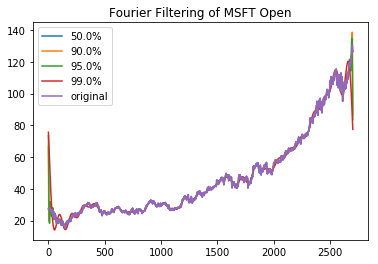

In [54]:
filterings = [0.5, 0.9, 0.95, 0.99]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for filt in filterings:
    res = Fourier_filter(msft_df['Open'].values, filter_percent=filt, plot=False)
    ax.plot(res, label='{}%'.format(filt*100))
ax.plot(msft_df['Open'].values, label='original')
l = ax.legend()
ax.set_title('Fourier Filtering of MSFT Open')
fig.show()

<a id="visualize_embeddings"></a>

## Visualize Word Embeddings

> One idea (__required for 7000 level students__): Use t-SNE (or SVD) to visualize the word embeddings of a subset of words in your vocabulary. Try to interpret what each dimension reflects (in your own words). That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding. 

<a id="tSNE"></a>

### t-SNE

For this section we will start with a embedding matrix of our vocabulary using GloVe 50, 100, 200, and 300. We will then use t-SNE to reduce the dimensionality to 2 dimensions. We will then find the lenght of the diffence vectors between two sets of words that we think are similar. We tried this with the text from the constitution as well as the first 10,000 words from the GloVe embeddings.

Also, t-SNE does not try to maintain distances so trying to compare the distances between vectors from a high dimension space to a low dimension space will not provide any information.

In [435]:
# first loat the constitution and clean it some
with open('texts/const.txt', 'r') as f:
    dat = f.read().lower()
    
word = ''
word_list = []
for c in dat:
    if c in ['\n']:
        c = ' '
    if c in [',', '.', ';']:
        continue
    if c == ' ': # new word
        if word != '':
            word_list.append(word)
        word = ''
    else:
        word += c
        
print('first 5 words: {}'.format(word_list[:5]))
print('total words found {}'.format(len(word_list)))

first 5 words: ['we', 'the', 'people', 'of', 'the']
total words found 7620


In [436]:
# now tokenize to get the dictionary
import keras
from keras.preprocessing.text import Tokenizer

NUM_TOP_WORDS=None

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(word_list)
sequences = tokenizer.texts_to_sequences(word_list)

word_index = tokenizer.word_index

In [437]:
embed_sizes = [50, 100, 200, 300]
full_size_embed_dict = {}
for EMBED_SIZE in embed_sizes:
    print('working on size {}'.format(EMBED_SIZE))
    # the embed size should match the file you load glove from
    embeddings_index = {}
    with open('glove.6B/glove.6B.{}d.txt'.format(EMBED_SIZE), 'r', encoding='utf-8') as f:
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    print('embedding matrix size {}'.format(embedding_matrix.shape))
    full_size_embed_dict[EMBED_SIZE] = embedding_matrix

working on size 50
Found 400000 word vectors.
embedding matrix size (1167, 50)
working on size 100
Found 400000 word vectors.
embedding matrix size (1167, 100)
working on size 200
Found 400000 word vectors.
embedding matrix size (1167, 200)
working on size 300
Found 400000 word vectors.
embedding matrix size (1167, 300)


In [441]:
# now use t-SNE to reduct dimensionality for each starting dimension
from sklearn.manifold import TSNE

reduced_size_embed_dict = {}
original_sizes = [50, 100, 200, 300]
for orig_size in original_sizes:
    print('now working on size {}'.format(orig_size))
    original_matrix = full_size_embed_dict[orig_size]
    print('original matrix size {}'.format(original_matrix.shape))
    reduced_matrix = TSNE(n_components=2).fit_transform(original_matrix)
    print('reduced matrix size {}'.format(reduced_matrix.shape))
    reduced_size_embed_dict[orig_size] = reduced_matrix

now working on size 50
original matrix size (1167, 50)
reduced matrix size (1167, 2)
now working on size 100
original matrix size (1167, 100)
reduced matrix size (1167, 2)
now working on size 200
original matrix size (1167, 200)
reduced matrix size (1167, 2)
now working on size 300
original matrix size (1167, 300)
reduced matrix size (1167, 2)


In [452]:
# now find the distances between words

word_pairs = [['representatives','members'],
              ['representatives','electors'],
              ['representatives','person'],
              ['members','electors'],
              ['members','person'],
              ['electors','person']]

original_sizes = [50, 100, 200, 300]

dict_of_lists = {}
for orig_size in original_sizes:
    results_list = []
    matrix = reduced_size_embed_dict[orig_size]
    for word_pair in word_pairs:
        i_1 = word_index[word_pair[0]]
        i_2 = word_index[word_pair[1]]
        v1 = matrix[i_1,:]
        v2 = matrix[i_2,:]
        d = np.linalg.norm((v1-v2))
        results_list.append(word_pair+[d])
    dict_of_lists[orig_size] = results_list

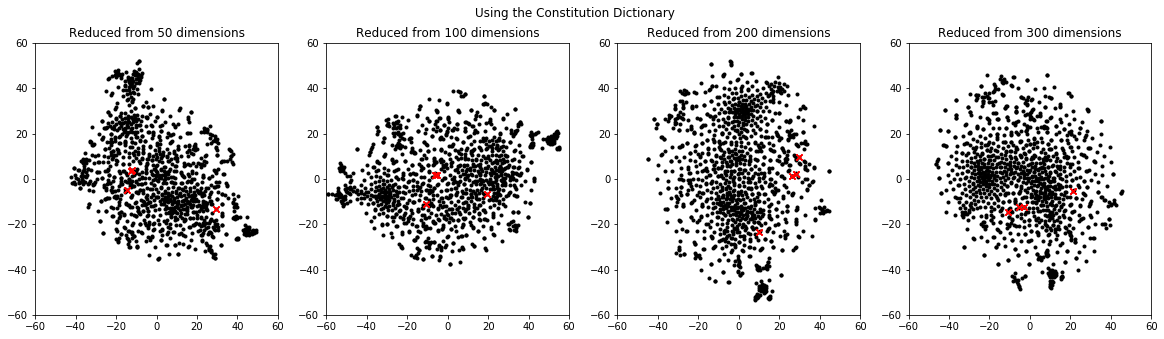

In [467]:
# now plot all of the words
original_sizes = [50, 100, 200, 300]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.suptitle('Using the Constitution Dictionary')
for i in range(len(original_sizes)):
    original_size = original_sizes[i]
    embed_mat = reduced_size_embed_dict[original_size]
    ax = axes[i]
    ax.set_title('Reduced from {} dimensions'.format(original_size))
    ax.scatter(embed_mat[:,0], embed_mat[:,1], marker='.', color='black')
    ax.set_ylim(-60, 60)
    ax.set_xlim(-60, 60)
    # now the special words
    for word_pair in word_pairs:
        i_1 = word_index[word_pair[0]]
        i_2 = word_index[word_pair[1]]
        v1 = embed_mat[i_1,:]
        v2 = embed_mat[i_2,:]
        ax.scatter(v1[0], v1[1], marker='x', color='red')
        ax.scatter(v2[0], v2[1], marker='x', color='red')

As we can see from the images above, the starting dimensionality of the GloVe embedding does change the shape of the distribution of points in 2-D after applying t-SNE. We can also see that the points in red, all form words we think are similar, are not necessarily close to each other in 2-D space.

Now we will try the same thing with the first 10,000 words from the GloVE embedding.

In [480]:
# now instead of using only the constitution vocabulary, use the first n_lines from the GloVe embedding and hope for the best

n_lines = 10000
embed_sizes = [50, 100, 200, 300]
full_size_glove_embed_dict = {}
glove_word_index = {}
for EMBED_SIZE in embed_sizes:
    print('working on size {}'.format(EMBED_SIZE))
    # the embed size should match the file you load glove from
    embeddings_glove_index = {}
    with open('glove.6B/glove.6B.{}d.txt'.format(EMBED_SIZE), 'r', encoding='utf-8') as f:
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
        i=0
        embedding_matrix = np.zeros((n_lines, EMBED_SIZE))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_glove_index[word] = coefs
            embedding_matrix[i] = coefs
            glove_word_index[word] = i

    print('Found %s word vectors.' % len(embeddings_index))

    print('embedding matrix size {}'.format(embedding_matrix.shape))
    full_size_glove_embed_dict[EMBED_SIZE] = embedding_matrix

working on size 50
Found 400000 word vectors.
embedding matrix size (10000, 50)
working on size 100
Found 400000 word vectors.
embedding matrix size (10000, 100)
working on size 200
Found 400000 word vectors.
embedding matrix size (10000, 200)
working on size 300
Found 400000 word vectors.
embedding matrix size (10000, 300)


In [481]:
# now use t-SNE to reduct dimensionality for each starting dimension
from sklearn.manifold import TSNE

reduced_size_glove_embed_dict = {}
original_sizes = [50, 100, 200, 300]
for orig_size in original_sizes:
    print('now working on size {}'.format(orig_size))
    original_matrix = full_size_glove_embed_dict[orig_size]
    print('original matrix size {}'.format(original_matrix.shape))
    reduced_matrix = TSNE(n_components=2).fit_transform(original_matrix)
    print('reduced matrix size {}'.format(reduced_matrix.shape))
    reduced_size_glove_embed_dict[orig_size] = reduced_matrix

now working on size 50
original matrix size (10000, 50)
reduced matrix size (10000, 2)
now working on size 100
original matrix size (10000, 100)
reduced matrix size (10000, 2)
now working on size 200
original matrix size (10000, 200)
reduced matrix size (10000, 2)
now working on size 300
original matrix size (10000, 300)
reduced matrix size (10000, 2)


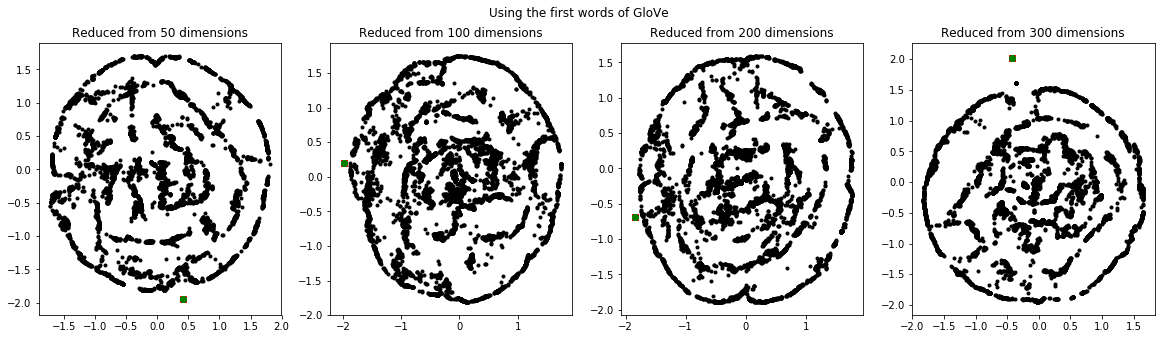

In [482]:
# now plot all of the words
original_sizes = [50, 100, 200, 300]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.suptitle('Using the first words of GloVe')
for i in range(len(original_sizes)):
    original_size = original_sizes[i]
    embed_mat = reduced_size_glove_embed_dict[original_size]
    ax = axes[i]
    ax.set_title('Reduced from {} dimensions'.format(original_size))
    ax.scatter(embed_mat[:,0], embed_mat[:,1], marker='.', color='black')
#    ax.set_ylim(-60, 60)
#    ax.set_xlim(-60, 60)
    # now the special words
    for word_pair in word_pairs:
        i_1 = glove_word_index[word_pair[0]]
        i_2 = glove_word_index[word_pair[1]]
        v1 = embed_mat[i_1,:]
        v2 = embed_mat[i_2,:]
        ax.scatter(v1[0], v1[1], marker='x', color='red')
        ax.scatter(v2[0], v2[1], marker='x', color='red')
    for word in ['state', 'states']:
        i_w = glove_word_index[word]
        v = embed_mat[i_w]
        ax.scatter(v[0], v[1], marker='o', color='green')

We can see that using the first words from the GloVe embedding instead of the vocabulary used in the constitution does change the final distribution after embedding in 2D. We can also see that the word pairs are all close to each other which agrees with our intuition that the words are similar.

Now we will use t-SNE and check how word differences behave. That is, we know that in the original dimensionality space the difference from "male" to "female" is similar to the difference between "king" and "queen". We will check if t-SNE preserves these analagies. We will also look at the words corresponding to the maximum and minimum values for each axis and see if we can tell what each axis encodes.

In [118]:
import numpy as np

n_lines = 10000
embed_sizes = [50]
full_size_glove_embed_dict = {}
glove_word_index = {}
glove_index_word = {}
for EMBED_SIZE in embed_sizes:
    print('working on size {}'.format(EMBED_SIZE))
    # the embed size should match the file you load glove from
    embeddings_glove_index = {}
    with open('glove.6B/glove.6B.{}d.txt'.format(EMBED_SIZE), 'r', encoding='utf-8') as f:
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
        i=0
        embedding_matrix = np.zeros((n_lines+1, EMBED_SIZE))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_glove_index[word] = coefs
            embedding_matrix[i] = coefs
            glove_word_index[word] = i
            glove_index_word[i] = word
            i+=1
            if i > n_lines:
                break
            

#    print('Found %s word vectors.' % len(embeddings_index))

    print('embedding matrix size {}'.format(embedding_matrix.shape))
    full_size_glove_embed_dict[EMBED_SIZE] = embedding_matrix

working on size 50
embedding matrix size (10001, 50)


In [119]:
%time
from sklearn.manifold import TSNE

full_mat = full_size_glove_embed_dict[50]
print('full size matrix {}'.format(full_mat.shape))
small_mat = TSNE(n_components=2).fit_transform(full_mat)
print('small size matrix {}'.format(small_mat.shape))

Wall time: 0 ns
full size matrix (10001, 50)
small size matrix (10001, 2)


In [120]:
n=15
smallest_a0_index = np.argpartition(small_mat[:,0],range(n))[:n]
smallest_a0_elements = [[small_mat[i,0], small_mat[i,1]] for i in smallest_a0_index]
smallest_a0_words = [glove_index_word[i] for i in smallest_a0_index]

largest_a0_index = np.argpartition(small_mat[:,0],range(-n,0,1))[-n:]
largest_a0_elements = [[small_mat[i,0], small_mat[i,1]] for i in largest_a0_index]
largest_a0_words = [glove_index_word[i] for i in largest_a0_index]

smallest_a1_index = np.argpartition(small_mat[:,1],range(n))[:n]
smallest_a1_elements = [[small_mat[i,0], small_mat[i,1]] for i in smallest_a1_index]
smallest_a1_words = [glove_index_word[i] for i in smallest_a1_index]

largest_a1_index = np.argpartition(small_mat[:,1],range(-n,0,1))[-n:]
largest_a1_elements = [[small_mat[i,0], small_mat[i,1]] for i in largest_a1_index]
largest_a1_words = [glove_index_word[i] for i in largest_a1_index]

print('smallest a0')
print(smallest_a0_words)
print('\nlargest a0')
print(largest_a0_words)
print('\nsmallest a1')
print(smallest_a1_words)
print('\nlargest a1')
print(largest_a1_words)

smallest a0
['rocked', 'erupted', 'clashes', 'sectarian', 'bloodshed', 'unrest', 'riots', 'reactors', 'reactor', 'violence', 'uranium', 'enrichment', 'violent', 'nuclear', 'atomic']

largest a0
['1891', '1898', '1889', '1888', '1894', '1892', '1890', '1860', '1885', '1870', '1864', '1863', '1862', '1865', '1861']

smallest a1
['powder', 'teaspoon', 'tablespoons', 'salt', 'pour', 'pan', 'olive', 'chopped', 'cups', 'pepper', 'pot', 'stir', 'garlic', 'mixture', 'medium']

largest a1
['koh', 'uh', 'nah', 'nee', 'mee', 'ee', 'bah', 'rah', 'mah', 'sah', 'ree', 'kah', 'yah', 'lah', 'hah']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


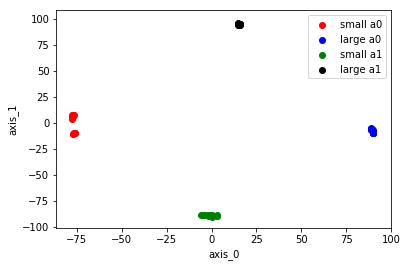

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('axis_0')
ax.set_ylabel('axis_1')
for i in range(len(smallest_a0_elements)):
    l = smallest_a0_elements[i]
    if i==0:
        ax.scatter(l[0], l[1], color='red', label='small a0')
    else:
        ax.scatter(l[0], l[1], color='red')
for i in range(len(largest_a0_elements)):
    l = largest_a0_elements[i]
    if i==0:
        ax.scatter(l[0], l[1], color='blue', label='large a0')
    else:
        ax.scatter(l[0], l[1], color='blue')
for i in range(len(smallest_a1_elements)):
    l = smallest_a1_elements[i]
    if i==0:
        ax.scatter(l[0], l[1], color='green', label='small a1')
    else:
        ax.scatter(l[0], l[1], color='green')
for i in range(len(largest_a1_elements)):
    l = largest_a1_elements[i]
    if i==0:
        ax.scatter(l[0], l[1], color='black', label='large a1')
    else:
        ax.scatter(l[0], l[1], color='black')
ax.legend()
fig.show()

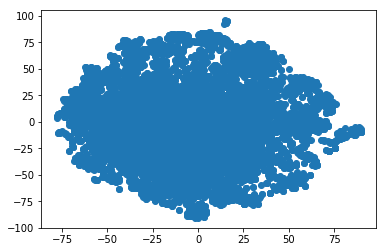

In [122]:
plt.scatter(small_mat[:,0], small_mat[:,1])

From the plots above we can tell that we were able to pull out the points and corresponding words which had the maximum and minimum values for each axis. However, it is difficult to tell what each axis encodes from the words (listed 2 cells up). 

Now we will look at words that have similar differences and check their behavior. We chose to look at male/female words as well as singular/plural words.

In [123]:
def plot_words(word_list, small_mat, plot_title = '', draw_vec = False):
    diff_list = []
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title(plot_title)
    for pair in word_list:
        male = pair[0]
        female = pair[1]
        try:
            m_i = glove_word_index[male]
            f_i = glove_word_index[female]
        except:
            continue
        m_v = small_mat[m_i, :]
        f_v = small_mat[f_i, :]
        diff_list.append(np.linalg.norm(m_v - f_v))
        ax.scatter(m_v[0], m_v[1], color='blue')
        ax.scatter(f_v[0], f_v[1], color='red')
        if draw_vec:
            ax.arrow(m_v[0], m_v[1], f_v[0]-m_v[0], f_v[1]-m_v[1])
    fig.show()
    return np.array(diff_list)

[ 0.54660827  1.9703404   2.6779225   1.468143   53.998734  ]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


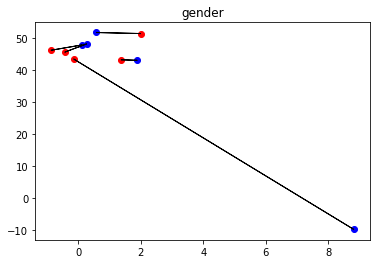

In [124]:
gender_list = [['man', 'woman'],['son', 'daughter'],['uncle','aunt'],['nephew','niece'],['king', 'queen'],['his', 'her']]

gender_diff = plot_words(gender_list, small_mat=small_mat, plot_title='gender', draw_vec=True)
print(gender_diff)

[62.654903  63.20717   23.341953   0.9673996]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


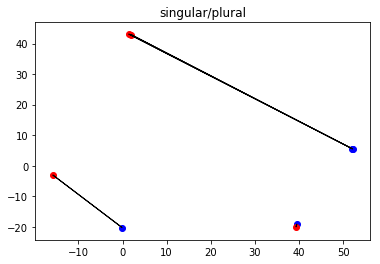

In [125]:
single_plural = [['men','man'], ['women','woman'], ['people','person'], ['years','year']]
single_plural_diff = plot_words(single_plural, small_mat=small_mat, plot_title='singular/plural', draw_vec=True)
print(single_plural_diff)

From the above plots we can see that using t-SNE does not seem to retain the analagy information that was encoded in the original embeddings. This is not totally surprising sicne t-SNE is intended to preserve probabilities not vector length differences.

<a id="PCA"></a>

### PCA

Now we will look at how using PCA for dimensionality reduction affects these results. We should note that since PCA is quicker than t-SNE, we chose to use the full embedding vocabulary of 400,000 words.

In [103]:
import numpy as np

n_lines = 400000-1
embed_sizes = [50]
full_size_glove_embed_dict = {}
glove_word_index = {}
glove_index_word = {}
for EMBED_SIZE in embed_sizes:
    print('working on size {}'.format(EMBED_SIZE))
    # the embed size should match the file you load glove from
    embeddings_glove_index = {}
    with open('glove.6B/glove.6B.{}d.txt'.format(EMBED_SIZE), 'r', encoding='utf-8') as f:
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
        i=0
        embedding_matrix = np.zeros((n_lines+1, EMBED_SIZE))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_glove_index[word] = coefs
            embedding_matrix[i] = coefs
            glove_word_index[word] = i
            glove_index_word[i] = word
            i+=1
            if i > n_lines:
                break
            

#    print('Found %s word vectors.' % len(embeddings_index))

    print('embedding matrix size {}'.format(embedding_matrix.shape))
    full_size_glove_embed_dict[EMBED_SIZE] = embedding_matrix

working on size 50
embedding matrix size (400000, 50)


In [104]:
%time
from sklearn.decomposition import PCA

full_mat = full_size_glove_embed_dict[50]
print('full size matrix {}'.format(full_mat.shape))
small_pca_mat = PCA(n_components=2).fit_transform(full_mat)
print('small size matrix {}'.format(small_pca_mat.shape))

Wall time: 0 ns
full size matrix (400000, 50)
small size matrix (400000, 2)


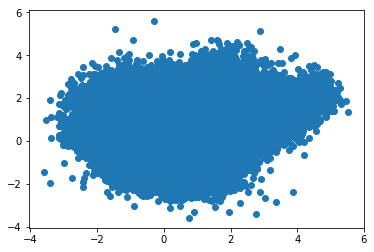

In [105]:
plt.scatter(small_pca_mat[:,0], small_pca_mat[:,1])

In [106]:
n=15
smallest_pca_a0_index = np.argpartition(small_pca_mat[:,0],range(n))[:n]
smallest_pca_a0_elements = [[small_pca_mat[i,0], small_pca_mat[i,1]] for i in smallest_pca_a0_index]
smallest_pca_a0_words = [glove_index_word[i] for i in smallest_pca_a0_index]

largest_pca_a0_index = np.argpartition(small_pca_mat[:,0],range(-n,0,1))[-n:]
largest_pca_a0_elements = [[small_pca_mat[i,0], small_pca_mat[i,1]] for i in largest_pca_a0_index]
largest_pca_a0_words = [glove_index_word[i] for i in largest_pca_a0_index]

smallest_pca_a1_index = np.argpartition(small_pca_mat[:,1],range(n))[:n]
smallest_pca_a1_elements = [[small_pca_mat[i,0], small_pca_mat[i,1]] for i in smallest_pca_a1_index]
smallest_pca_a1_words = [glove_index_word[i] for i in smallest_pca_a1_index]

largest_pca_a1_index = np.argpartition(small_pca_mat[:,1],range(-n,0,1))[-n:]
largest_pca_a1_elements = [[small_pca_mat[i,0], small_pca_mat[i,1]] for i in largest_pca_a1_index]
largest_pca_a1_words = [glove_index_word[i] for i in largest_pca_a1_index]

print('smallest a0')
print(smallest_pca_a0_words)
print('\nlargest a0')
print(largest_pca_a0_words)
print('\nsmallest a1')
print(smallest_pca_a1_words)
print('\nlargest a1')
print(largest_pca_a1_words)

smallest a0
['rungfapaisarn', 'fredesvindo', 'rosnazura', 'adek', 'renois', 'zablit', 'embalo', 'trouillaud', 'shusham', 'chandrapala', 'mutond', 'aarsaether', 'sefko', 'wivina', 'lebouachera']

largest a0
['four', 'all', 'up', 'which', 'in', 'it', 'the', 'have', 'more', 'than', 'some', 'they', 'into', 'their', 'its']

smallest a1
['timaliids', 'paginated', 'modifiying', '212-621-5449', 'shared-time', 'point-scorers', 'detraining', 'rosicruciana', 'inter-10', 'officership', 'gastrappet', 'non-primary', 'yakutiya', 'two-leg', 'unclench']

largest a1
['chairman', 'director', 'l.', 'jr.', 'michael', 'gen.', 'chief', 'minister', 'spokesman', 'dr.', '202-887-8334', 'j.', 'said', '202-887-8316', '404-582-7282']


From the max/min values for each axis it is still difficult to see what each axis encodes. There appear to be many words that are not used often. Now we will look at the differences of words.

[0.7433523  0.45813033 0.87458101 0.94471947 1.32499746 0.50907767]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


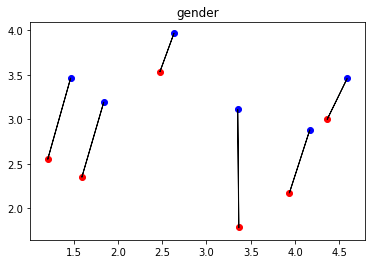

In [107]:
gender_list = [['man', 'woman'],['son', 'daughter'],['uncle','aunt'],['nephew','niece'],['king', 'queen'],['his', 'her']]

pca_gender_diff = plot_words(gender_list, small_mat=small_pca_mat, plot_title='gender', draw_vec=True)
print(pca_gender_diff)

[2.5136099e+00 5.9866697e-01 1.5165675e+00 1.9985460e-05]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


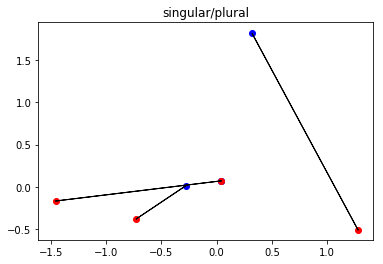

In [108]:
single_plural = [['men','man'], ['women','woman'], ['people','person'], ['years','year']]
pca_single_plural_diff = plot_words(single_plural, small_mat=small_mat, plot_title='singular/plural', draw_vec=True)
print(pca_single_plural_diff)

We can see that PCA appears to do a better job of preserving the male/female analagy (although not perfectly). However, it still does not seem to include any singular/plural analagy.

<a id="novel_text"></a>

## Novel Text

> Another Idea (NOT required): Try to create a RNN for generating novel text. 

<a id="word_by_word"></a>

### Word by Word

Now we will train a model on Pride and Prejudice and try to predict the next words.

In [4]:
with open('Archive_2/1342-0.txt', 'r', encoding='utf-8') as f:
    dat = f.read().lower()
    
i = 0
word = ''
word_list = []
for c in dat:
    if c in ['\n']:
        c = ' '
    if c in [',', '.', ';']:
        continue
    if c == ' ': # new word
        if word != '':
            word_list.append(word)
        word = ''
    else:
        word += c

tmp_list = []
for i in word_list:
    if i.isalpha:
        tmp_list += [i]
word_list = tmp_list

In [5]:
text_train = []
for i in range(len(word_list)-31):
    text_train += [[''.join([word+' ' for word in word_list[i:i+30]]), word_list[i+30]]]

In [16]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Input, Model
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, LSTM, RNN, GRU
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import keras.backend as K
import gc
from keras.callbacks import EarlyStopping

In [12]:
text_df = pd.DataFrame(text_train)

In [13]:
text_df.head()

,0,1
0,﻿the project gutenberg ebook of pride and prej...,may
1,project gutenberg ebook of pride and prejudice...,copy
2,gutenberg ebook of pride and prejudice by jane...,it
3,ebook of pride and prejudice by jane austen th...,give
4,of pride and prejudice by jane austen this ebo...,it


In [14]:
text_df.dropna(inplace=True)

In [17]:
NUM_TOP_WORDS = None
MAX_ART_LEN = 30 # maximum and minimum number of words


#to make sure each news is MAX_ART_LEN, thus seperatable
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)

tokenizer.fit_on_texts(text_df[0])

sequences = tokenizer.texts_to_sequences(text_df[0])
text_X = pad_sequences(sequences, maxlen=MAX_ART_LEN,padding='pre')


word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(text_df[1])
Y = pad_sequences(sequences, maxlen=1,padding='pre')
Y = to_categorical(Y, num_classes=vocab_size)
print(Y.shape)

Found 7627 unique tokens. Distilled to 7627 top words.
(124561, 7628)


In [20]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B/glove.6B.'+str(EMBED_SIZE)+'d.txt', encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(7628, 100)
Wall time: 13 s


In [ ]:
if False:
    Y = np.zeros((len(text_X), EMBED_SIZE))
    for i, word in enumerate(text_df[1].values):
        if word in embeddings_index:
            Y[i,:] = embeddings_index.get(word)

In [ ]:
EMBED_SIZE = 100
input_holder = Input(shape=(text_X.shape[1], ))

embedding_layer = Embedding(vocab_size,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

rnn = Sequential()
rnn.add(embedding_layer)
#rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
rnn.add(LSTM(300,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(vocab_size, activation='softmax'))


rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(rnn.summary())

In [ ]:
rnn.fit(text_X, Y, epochs=300, batch_size=256)

In [21]:
word_list = list(set(word_list))

def write_text(string,length):
    print(string,end = ' ')
    for _ in range(length):
        seq = tokenizer.texts_to_sequences([string])
        x_test = pad_sequences(seq, maxlen=MAX_ART_LEN,padding='pre')
        yhat = rnn.predict_classes(x_test)[0]
        pred_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                pred_word = word
                break
        string = ''.join([' '+ word for word in (string.split()[1:]+[pred_word])])
        print(pred_word, end=' ')

In [22]:
write_text('As we move forward in this class, we will be transitioning more',200)

As we move forward in this class, we will be transitioning more prove where finally purposely acknowledged extent apprehension nor were visitors left neither could return first praise first entering the circumstance were disposed kept expected almost impossible to go conjectures leaving netherfield lydia should talk upon fishing enough otherwise to engagements on comfortable where concern cousin regiment only sooner she added little much delight to meet “what while honoured making form of their punctuality making park hurried thither arose our master was thinking pleased me reasonable past eagerly language beginning playing where miles all women can visit pass first christmas engagements arose were informed that they were within twenty yards dear mr bennet” making general good connection also allowed happen that leads education handsome written page contact directions hand visit them all”  cousin men ladies men are maria deserve them otherwise absence were neither rational wish fair ta

In [ ]:
for _ in range(20):
    rnn.fit(text_X, Y, epochs=1, batch_size=256)
    write_text('As we move forward in this class, we will be transitioning more',100)

In [ ]:
model_json = rnn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
rnn.save_weights("model.h5")
print("Saved model to disk")

In [2]:
from keras.models import model_from_json

with open('Archive_2/model.json', 'r') as f:
    rnn = model_from_json(f.read())
    
rnn.load_weights('Archive_2/model.h5')

<a id="character_by_character"></a>

### Character by Character

Now we will loat the constitution and analyze it character by character. In this method we have a smaller set of possible choices, but we lose information contained in the embeddings.

In [318]:
with open('texts/const.txt', 'r') as f:
    const = f.read().lower()
print('const len {}'.format(len(const)))

const len 44841


In [319]:
chars = sorted(list(set(const))) # get unique characters
print('total chars {}'.format(len(chars)))

total chars 46


In [320]:
# make dictioinaries for going back and forth between chars and indices
char_indices = dict((c,i) for i, c in enumerate(chars))
indices_char = dict((i,c) for i, c in enumerate(chars))

In [321]:
# now build the data sets. They consist of "sentences" of characters for the data and a target that is the next character
max_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(const) - max_len, step):
    sentences.append(const[i:i+max_len])
    next_chars.append(const[i+max_len])
    
x = np.zeros((len(sentences), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [322]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
    
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               89600     
_________________________________________________________________
dense_32 (Dense)             (None, 46)                5934      
_________________________________________________________________
activation_5 (Activation)    (None, 46)                0         
Total params: 95,534
Trainable params: 95,534
Non-trainable params: 0
_________________________________________________________________
None


We will include several semi-custom callbacks that are modified versions of sampels from keras documentation. We are not convinced that using on_epoch_end callbacks are necessarily cleaner than just training the model one epoch at a time in a loop and predicting after training, but this shows it can be done.

In [323]:
# helper functions from official LSTM text generation example from Keras Team
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
import random
import sys

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

writefile=open('texts/const_out.txt','a+')
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    print('----- Generating text after Epoch: %d' % epoch, file=writefile)
    
    start_index = 0
    #start_index = random.randint(0, len(const) - max_len - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)
        print('----- diversity:', diversity, file=writefile)

        generated = ''
        #sentence = const[start_index: start_index + max_len]
        sentence = 'amendment 28'
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        print('----- Generating with seed: "' + sentence + '"', file=writefile)
        sys.stdout.write(generated)
        print(generated, file=writefile)

        for i in range(400):
            x_pred = np.zeros((1, max_len, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            print(next_char,file=writefile, end='')
            sys.stdout.flush()
        print()
        print(file=writefile)
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

chkpt_filepath = 'model_checkpoints/weights.hdf5'
checkpoint = ModelCheckpoint(chkpt_filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)
#csv_logger = CSVLogger('texts/const_pred.log')
callbacks = [print_callback, checkpoint, reduce_lr]

In [324]:
model.fit(x, y, batch_size=128, epochs=2, callbacks=callbacks)
writefile.close()

Epoch 1/2
14934/14934 [==============================] - 11s 704us/step - loss: 2.5570

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "amendment 28"
amendment 28eoeeioetioieoeoee etiiooe eeioo ooeei et eee o eee eies ioeti   eieeteeoo see ieoee  oeeeoe t eie tee t  oei te eoo ietoieei ei oot eo eoe e eoee ioeio o oeeooeesi see iteoee eeieoieoeeeee  eoe iteoeeeeoeeee oeio eoe  eooeoiroe e oeeeeoeoeio eeeio ee eeeieeoieeoeee eeteo  eeeee  oeeoteoeie eoeeoioeoeie e o ei ee s eo  eeeeeieae t  eeeeoeioeoeoe eeioateeoo  eooeeeeoiteeoeo  eeeoeeoeee eeieieoeeeoee
----- diversity: 0.5
----- Generating with seed: "amendment 28"
amendment 28 tlio otcee etoioee nii-tsee oeaetsoen  aeoieacigti  rtetoobei e taoaoie  iatoeesan mtiaeototes seso co titooestote otetoees reog it oo oi taeittosts soi  eiie oe  to co oldgoio  esteee a tt,oosetev  tosetseoeoa s niootneeete c oeteepei oe n  eo oteeoe  s  neeeteottetiott  eitti eioveiamoeeene nieeis ereoemeooeei ioas  i

KeyboardInterrupt: 

We can see (before the keyboard interrupt) that precidting the next character of the constitution did not seem to yeild very good results. We should note that we had previously trained the model for several epochs so the results here are reasonable, but not great. In principle we could train for much longer or train on a larger set of documents, but this part of the lab is mostly to see if we can do it or not.